# Simple project for Iris classification using logistic regression

Text(0, 0.5, '$logistic(z)$')

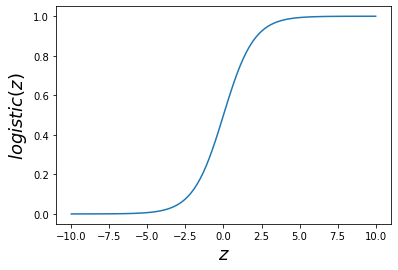

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic)
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$logistic(z)$', fontsize=18)

In [3]:
import seaborn as sns 
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


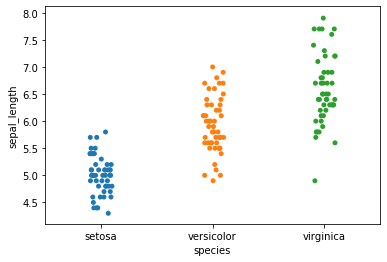

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)

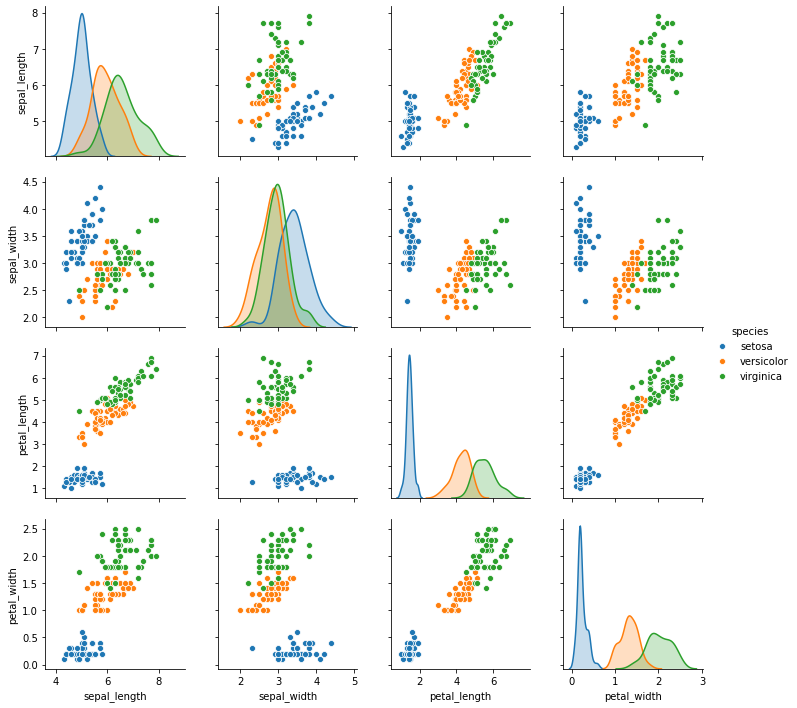

In [5]:
sns.pairplot(iris, hue='species', diag_kind='kde')

# Training and making predication

In [6]:
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import theano.tensor as tt

C:\Users\Owner\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [7]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values

logp = -41.726, ||grad|| = 3.5299e-05: 100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 2103.14it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 6000/6000 [00:12<00:00, 485.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
C:\Users\Owner\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Owner\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Owner\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarni

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002858CEC8A48>,
      dtype=object)

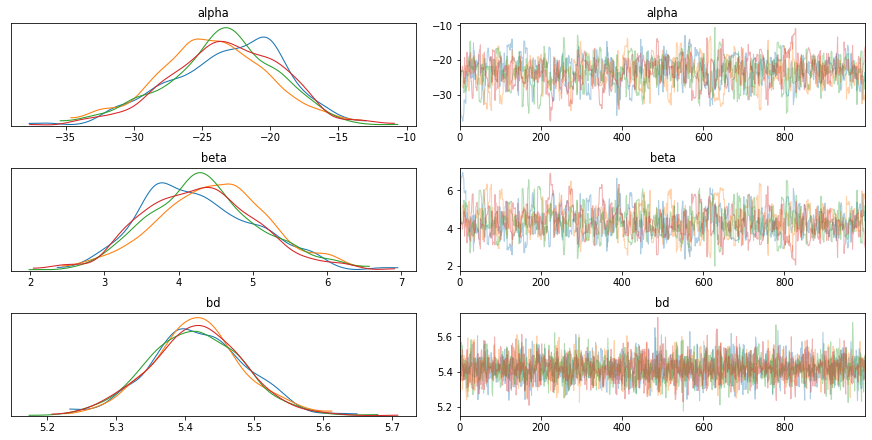

In [8]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)

    mu = alpha + pm.math.dot(x_0, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', -alpha/beta)

    yl = pm.Bernoulli('yl', theta, observed=y_0)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sampling.sample(1000, step, start)
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(trace_0, varnames)

In [9]:
pm.summary(trace_0, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-23.544,4.157,-31.503,-16.025,0.194,0.138,460.0,454.0,462.0,628.0,1.01
beta,4.347,0.769,2.980,5.849,0.036,0.025,462.0,457.0,464.0,617.0,1.01
bd,5.417,0.068,5.290,5.546,0.001,0.001,3364.0,3364.0,3364.0,3088.0,1.00


Text(0, 0.5, '$\\theta$')

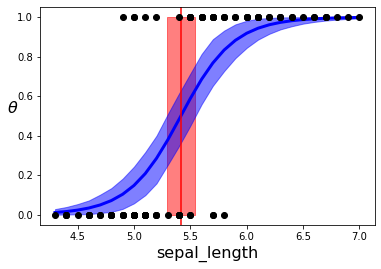

In [10]:
theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_0['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)


plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_0['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)


plt.xlabel(x_n, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)

In [11]:
def classify(n, threshold):
    """
    A simple classifying function
    """
    n = np.array(n)
    mu = trace_0['alpha'].mean() + trace_0['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob >= threshold

classify([5, 5.5, 6], 0.5)

(array([0.14054036, 0.58963985, 0.92661119]), array([False,  True,  True]))